# Individual Assignments 3 - Probability Based Learning
    Author: Bin Liao
    Student ID: 3109220

## 1. Instructions:
The Centers for Medicare & Medicaid Services (CMS) rates hospitals in the U.S. on a scale of 1-5 to make it easier for patients and consumers to compare the quality of services offered by hospitals. The tasks of this assignment is to build a classification model to but a tool to help patients choose a hospital.

### 1.1 Data source:
The data necessary for the building the model is available in **hospital.csv** and **hospital_not_yet_rated.csv** on https://github.com/dearbharat/datasets

### 1.2 Data Dictionary:
- **Hospital Demographic Information**: This includes Provider ID (or, in other words, the Hospital ID), Hospital Name, Zip, Area, State, etc.
- **Hospital overall rating**: Overall rating of the hospital. By default, CMS rates hospitals on ratings 1-5.
- **Hospital Quality Information**: These are the columns that describe the scores received by hospitals based on different quality measures. These quality measures as defined by CMS (as per the year when the data was collected) are as follows:
    - Mortality
    - Safety of Care
    - Readmission
    - Patient Experience
    - Effectiveness of Care
    - Timeliness of Care
    - Efficient Use of Medical Imaging   

- Each qualitative measure has been quantified in 2 ways:
    - **Measure national comparison**: For e.g., for a hospital's Mortality score, you can refer to the column 'Mortality National Comparison'. The score information can be understood as follows:
        - A score of 2 indicates the hospital performs better than the national average
        - A score of 1 indicates the hospital's performance is similar to the national average
        - A score of 0 indicates the hospital's performance is worse than the national average
    - **Sub-Measure** level information: For each of the measures, you also have the information of their sub-measures and their respective scores as well. This has been encoded in the following format: For e.g., for a hospital's Mortality sub-measure, you can find them in all the columns which have a MORT prefix in them (like MORT_30_AMI_Score). Each of the sub-measures has a  combined effect on the overall measure rating of a hospital.

### 1.3 Import the library

In [67]:
import pandas as pd
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns


## 2. Undestand the data

### 2.1 Load the data

In [68]:
# load the hospital data
hospital_df = pd.read_csv("https://raw.githubusercontent.com/dearbharat/datasets/main/hospital.csv")

# load the hospital not yet rated data
not_rated_df = pd.read_csv("https://raw.githubusercontent.com/dearbharat/datasets/main/hospital_not_yet_rated.csv")

# inspect the key variables
print(hospital_df.columns)


Index(['Provider ID', 'Hospital Name', 'Address', 'City', 'State', 'ZIP Code',
       'County Name', 'Phone Number', 'Hospital Ownership',
       'Emergency Services', 'Hospital overall rating',
       'Mortality national comparison', 'Safety of care national comparison',
       'Readmission national comparison',
       'Patient experience national comparison',
       'Effectiveness of care national comparison',
       'Timeliness of care national comparison',
       'Efficient use of medical imaging national comparison',
       'MORT_30_AMI_Score', 'MORT_30_CABG_Score', 'MORT_30_COPD_Score',
       'MORT_30_HF_Score', 'MORT_30_PN_Score', 'MORT_30_STK_Score',
       'rating_group', 'READM_30_AMI_Score', 'READM_30_CABG_Score',
       'READM_30_COPD_Score', 'READM_30_HF_Score', 'READM_30_HIP_KNEE_Score',
       'READM_30_HOSP_WIDE_Score', 'READM_30_PN_Score', 'READM_30_STK_Score',
       'TIME_OP_21_Score', 'TIME_OP_5_Score', 'EFF_EDV_Score',
       'EFF_ED_1b_Score', 'EFF_ED_2b_Score', 

In [69]:
# explore the hostpital datasets
hospital_df.head()

,Provider ID,Hospital Name,Address,City,State,ZIP Code,County Name,Phone Number,Hospital Ownership,Emergency Services,...,SAFETY_HAI_3_SIR_Score,SAFETY_HAI_4_SIR_Score,SAFETY_HAI_5_SIR_Score,SAFETY_HAI_6_SIR_Score,MED_OP_10_Score,MED_OP_11_Score,MED_OP_13_Score,MED_OP_14_Score,MED_OP_8_Score,MED_OP_9_Score
0,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,Government,Yes,...,-1.87000,-0.000000,-0.422000,-0.787,-6.4,-0.900000,-7.100000,-2.400000,-38.100000,-6.9
1,10005,MARSHALL MEDICAL CENTER SOUTH,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,MARSHALL,2565938310,Government,Yes,...,-0.38600,-0.871177,-1.388000,-0.405,-13.3,-10.200000,-5.300000,-4.000000,-42.800000,-5.1
2,10006,ELIZA COFFEE MEMORIAL HOSPITAL,205 MARENGO STREET,FLORENCE,AL,35631,LAUDERDALE,2567688400,Government,Yes,...,-0.31000,-0.871177,-1.261000,-0.513,-11.8,-4.600000,-0.000000,-4.600000,-45.600000,-9.1
3,10007,MIZELL MEMORIAL HOSPITAL,702 N MAIN ST,OPP,AL,36467,COVINGTON,3344933541,Voluntary,Yes,...,-0.96398,-0.871177,-0.987212,-0.000,-24.3,-6.100000,-4.716942,-2.964405,-39.964766,-20.7
4,10008,CRENSHAW COMMUNITY HOSPITAL,101 HOSPITAL CIRCLE,LUVERNE,AL,36049,CRENSHAW,3343353374,Others,Yes,...,-0.96398,-0.871177,-0.987212,-0.585,-3.6,-2.936245,-4.716942,-0.600000,-39.964766,-8.2


### 2.2 Data Exploration
- The dataset consistns of 96 columns and 3057 of rows.
- Apart from the "Hospital Demographic Information" columns, columns are either floats or integers.
- Our target columns is "Hospital overall rating".

In [70]:
# The hospital dataset info
print(hospital_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3057 entries, 0 to 3056
Data columns (total 94 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   Provider ID                                           3057 non-null   int64  
 1   Hospital Name                                         3057 non-null   object 
 2   Address                                               3057 non-null   object 
 3   City                                                  3057 non-null   object 
 4   State                                                 3057 non-null   object 
 5   ZIP Code                                              3057 non-null   int64  
 6   County Name                                           3057 non-null   object 
 7   Phone Number                                          3057 non-null   int64  
 8   Hospital Ownership                                    3057

### 2.3 "hospital overall ratings" insights

In [71]:
# summary statistics of hospital overall rating
print(hospital_df['Hospital overall rating'].describe())

count    3057.000000
mean        3.025842
std         0.869600
min         1.000000
25%         2.000000
50%         3.000000
75%         4.000000
max         5.000000
Name: Hospital overall rating, dtype: float64


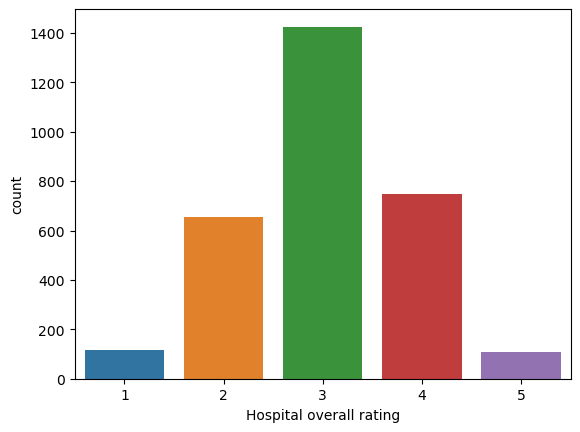

In [72]:
# distribution of hospital overall rating
sns.countplot(x='Hospital overall rating', data=hospital_df)
plt.show()

- The distribution of hospital overall ratings is slightly skewed to the right, with a larger proportion of hospitals having an overall rating of 3 or higher. This suggests that most hospitals in the dataset are performing relatively well in terms of the quality measures considered by CMS.

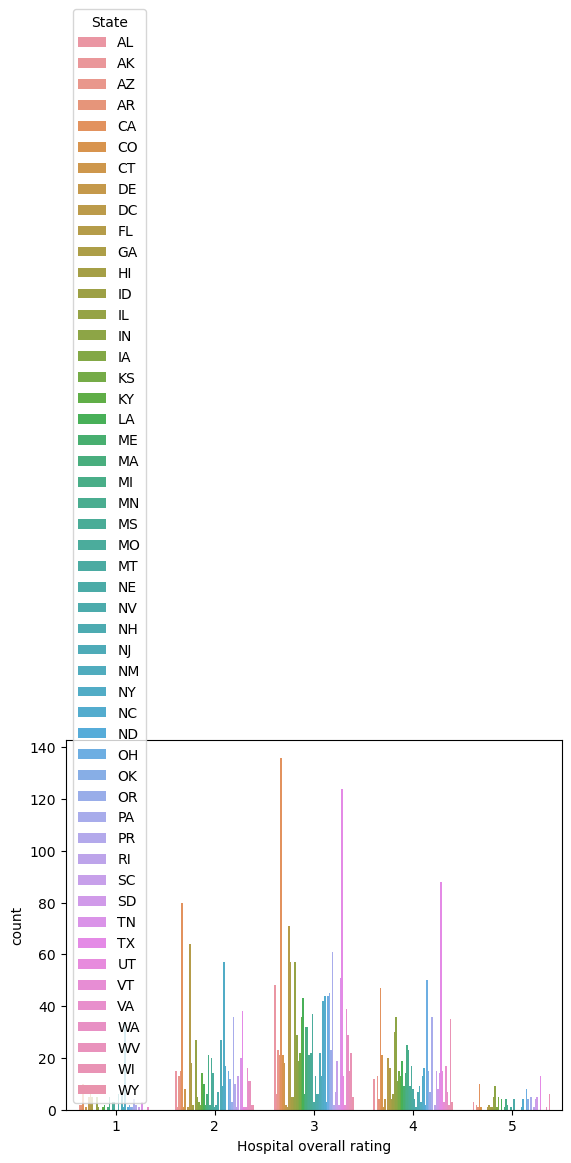

In [73]:
# distribution of hospital overall rating by state
sns.countplot(x='Hospital overall rating', hue='State', data=hospital_df)
plt.show()

- The distribution of hospital overall ratings varies across different states. Some states have a higher proportion of hospitals with higher overall ratings, while other states have a higher proportion of hospitals with lower overall ratings. For example, California has a higher proportion of hospitals with overall rating 3 or higher, while Texas has a higher proportion of hospitals with overall rating 2 or lower.

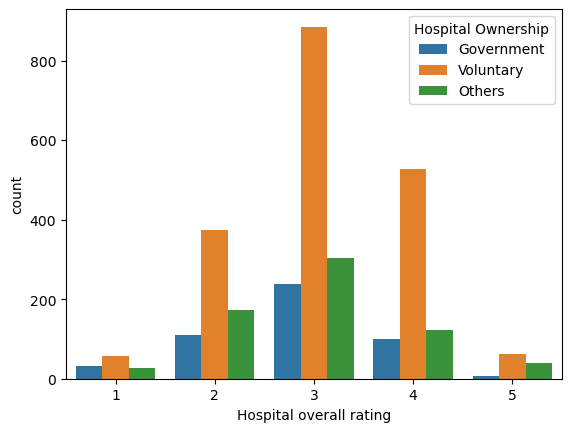

In [74]:
# distribution of hospital overall rating by Hospital Ownership
sns.countplot(x='Hospital overall rating', hue='Hospital Ownership', data=hospital_df)
plt.show()

- The distribution of hospital overall ratings varies 'Hospital Ownership' indicates that the hopital owns by voluntary tend to have a higher proporitiron of higher over all ratings, compared to hospitals that owned by the government or others.

## 3. Building Machine Learning Models
### 3.1 Building the model
- Remove all the demographic columns and other unnecessary features
- Instead of 1 - 5 ratings, convert it to 0 and 1 using 1,2,3 as 0 and 4,5: 1
- Create the dummy variables for categorical columns as necessary.
- Split the data into train and test sets (70-30 split)
- Scale the numerical columns using StandardScaler.

In [75]:
# select relevant columns and convert overall rating to binary
X = hospital_df[['Mortality national comparison', 'Safety of care national comparison',
       'Readmission national comparison', 'Patient experience national comparison',
       'Effectiveness of care national comparison', 'Timeliness of care national comparison',
       'Efficient use of medical imaging national comparison']]
y = hospital_df['Hospital overall rating'].apply(lambda x: 0 if x <= 3 else 1)

# create dummy variables for categorical columns
X = pd.get_dummies(X, drop_first=True)

# split data into train and test sets (70-30 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# scale numerical columns
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


### 3.2 Fitting the Model

Instantiate the Gaussian Naive Bayes model and Decision Tree classifers, then fit it on the train dataset

In [76]:
# build Naive Bayes classifier
nb_clf = GaussianNB()
nb_clf.fit(X_train, y_train)

# build Decision Tree classifier
dt_clf = DecisionTreeClassifier(random_state=42)
dt_clf.fit(X_train, y_train)



DecisionTreeClassifier(random_state=42)

### 3.3 Model Prediction

Evaluate with the **Naive Bayes** and **Decision Tree** classifiers on the the test dataset.

In [77]:
# evaluate model performance on test set
nb_preds = nb_clf.predict(X_test)
dt_preds = dt_clf.predict(X_test)


print("Naive Bayes Classifier Performance:")
print("Accuracy: ", accuracy_score(y_test, nb_preds))
print("Precision: ", precision_score(y_test, nb_preds))
print("Recall: ", recall_score(y_test, nb_preds))
print("F1-Score: ", f1_score(y_test, nb_preds))
print("\nNaive Bayes Classifier classification reposrt:")
print(classification_report (y_test, nb_preds))

print("\nDecision Tree Classifier Performance:")
print("Accuracy: ", accuracy_score(y_test, dt_preds))
print("Precision: ", precision_score(y_test, dt_preds))
print("Recall: ", recall_score(y_test, dt_preds))
print("F1-Score: ", f1_score(y_test, dt_preds))
print("\nDecision Tree Classifier classification reposrt:")
print(classification_report (y_test, dt_preds))


Naive Bayes Classifier Performance:
Accuracy:  0.8660130718954249
Precision:  0.7811158798283262
Recall:  0.7165354330708661
F1-Score:  0.7474332648870636

Naive Bayes Classifier classification reposrt:
              precision    recall  f1-score   support

           0       0.89      0.92      0.91       664
           1       0.78      0.72      0.75       254

    accuracy                           0.87       918
   macro avg       0.84      0.82      0.83       918
weighted avg       0.86      0.87      0.86       918


Decision Tree Classifier Performance:
Accuracy:  0.8616557734204793
Precision:  0.7748917748917749
Recall:  0.7047244094488189
F1-Score:  0.7381443298969071

Decision Tree Classifier classification reposrt:
              precision    recall  f1-score   support

           0       0.89      0.92      0.91       664
           1       0.77      0.70      0.74       254

    accuracy                           0.86       918
   macro avg       0.83      0.81      0.82 

### 3.4 Outcome

1. Both the Naive Bayes and Decision Tree classifiers have similar overall performance, with an accuracy of around 86% on the test set. Indeed, the accuracy of Navive Bayes is 86.6%, and the accuracy of Dcision Tree classfiers is 86.1%.

2. The Naive Bayes classifier has a slightly higher precision score than the Decision Tree classifier for the positive class (hospital overall rating of 4 or 5), while the Decision Tree classifier has a slightly higher recall score for the positive class.

3. Both classifiers have relatively high precision and recall scores for the negative class (hospital overall rating of 1, 2, or 3), with the Naive Bayes classifier performing slightly better in terms of recall.

4. The F1-scores for both classifiers are also similar, with the Naive Bayes classifier having a slightly higher F1-score for the positive class and the Decision Tree classifier having a slightly higher F1-score for the negative class.

Overall, both classifiers have reasonably good performance in predicting hospital overall ratings. The Naive Bayes has a slightly better perfomace. So we will choose the Naive Bayes for the next task on recomendation.


## 4. Recomandations
According to the classification report result from the previous task, we will choose the Naive Bayes to make the recommendation.

### 4.1 Hospital Rating Predictor:

In [78]:
# select relevant columns from the not rated data file and create dummy variables
X_new = not_rated_df [['Mortality national comparison', 'Safety of care national comparison',
       'Readmission national comparison', 'Patient experience national comparison',
       'Effectiveness of care national comparison', 'Timeliness of care national comparison',
       'Efficient use of medical imaging national comparison']]
X_new = pd.get_dummies(X_new, drop_first=True)

# scale numerical columns
scaler = StandardScaler()
X_new = scaler.fit_transform(X_new)

# use Naive Bayes classifier to predict hospital ratings
new_ratings = nb_clf.predict(X_new)

# print predicted hospital ratings
print(new_ratings)



[1 1 0 0 0 0]


In [79]:
# combine predicted ratings with Provider ID and Hospital Name columns
not_rated_df['Predicted Rating'] = new_ratings

# print results as table
print(not_rated_df[['Provider ID','Predicted Rating']])

   Provider ID  Predicted Rating
0       520139                 1
1       520189                 1
2       370029                 0
3       370032                 0
4       370036                 0
5       370037                 0


### 4.2 Hospital Improvement Plan:

In [80]:
# identify hospitals with 0 ratings
zero_ratings_df = hospital_df[hospital_df['Hospital overall rating'] == 0]

# identify hospitals with 0 ratings
zero_ratings_df = hospital_df[hospital_df['Hospital overall rating'] == 0]

if not zero_ratings_df.empty:
    # add predicted ratings to zero_ratings_df
    zero_ratings_df['Predicted Rating'] = nb_clf.predict(pd.get_dummies(zero_ratings_df[X.columns], drop_first=True))

    # combine with hospital demographics
    new_ratings = zero_ratings_df[['Provider ID', 'Hospital Name', 'Predicted Rating']]

    # print out as a table
    print("Identify hospitals with a rating of 0.")
    print(new_ratings)
else:
    # identify hospitals with ratings of 3 or below
    low_ratings_df = hospital_df[hospital_df['Hospital overall rating'] <= 3]

    if not low_ratings_df.empty:
        # predict ratings for low-rated hospitals
        low_ratings_df.loc[:, 'Predicted Rating'] = nb_clf.predict(pd.get_dummies(low_ratings_df[X.columns], drop_first=True))

        # combine with hospital demographics
        new_ratings = low_ratings_df[['Provider ID', 'Hospital Name', 'Predicted Rating']]

        # print out as a table
        print("Identify hospitals with a rating of 3 or below.")
        print(new_ratings.head(10))
    else:
        print("No hospitals with 0 ratings or ratings of 3 or below were found.")



Identify hospitals with a rating of 3 or below.
    Provider ID                     Hospital Name  Predicted Rating
0         10001  SOUTHEAST ALABAMA MEDICAL CENTER                 1
1         10005     MARSHALL MEDICAL CENTER SOUTH                 1
2         10006    ELIZA COFFEE MEMORIAL HOSPITAL                 1
3         10007          MIZELL MEMORIAL HOSPITAL                 1
4         10008       CRENSHAW COMMUNITY HOSPITAL                 1
5         10011                 ST VINCENT'S EAST                 1
6         10012    DEKALB REGIONAL MEDICAL CENTER                 1
7         10016     SHELBY BAPTIST MEDICAL CENTER                 1
8         10019    HELEN KELLER MEMORIAL HOSPITAL                 0
10        10022           CHEROKEE MEDICAL CENTER                 1


/Users/binliao/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but GaussianNB was fitted without feature names
  warnings.warn(
/var/folders/xf/ndnycc4j18x9kc8tx40krlw80000gn/T/ipykernel_75345/2773831890.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  low_ratings_df.loc[:, 'Predicted Rating'] = nb_clf.predict(pd.get_dummies(low_ratings_df[X.columns], drop_first=True))


From the result, there is no hospital with 0 ratings. So we choose the hosiptal with a rating of 3 or below to apply on the Naive Bayes classification.

#### 4.2.1 'MARSHALL MEDICAL CENTER SOUTH' recommandation

As the result, we select the 'MARSHALL MEDICAL CENTER SOUTH' Hosipital with the Provider Id **10005** to do the recommandation.

In [81]:
hospital_10005 = hospital_df[hospital_df['Provider ID'] == 10005]

# print out the scores for the different quality measures
print("Quality Measures for Hospital 10005:")
print("Mortality Score:", hospital_10005['Mortality national comparison'].values[0])
print("Safety of Care Score:", hospital_10005['Safety of care national comparison'].values[0])
print("Readmission Score:", hospital_10005['Readmission national comparison'].values[0])
print("Patient Experience Score:", hospital_10005['Patient experience national comparison'].values[0])
print("Effectiveness of Care Score:", hospital_10005['Effectiveness of care national comparison'].values[0])
print("Timeliness of Care Score:", hospital_10005['Timeliness of care national comparison'].values[0])
print("Efficient Use of Medical Imaging Score:", hospital_10005['Efficient use of medical imaging national comparison'].values[0])

Quality Measures for Hospital 10005:
Mortality Score: 0
Safety of Care Score: 1
Readmission Score: 2
Patient Experience Score: 1
Effectiveness of Care Score: 1
Timeliness of Care Score: 2
Efficient Use of Medical Imaging Score: 0


Based on the data, it seems like the MARSHALL MEDICAL CENTER SOUTH hospital has lower scores in the following measures:

- Mortality
- Efficient use of medical imaging

To improve the ratings, the hospital could focus on the following areas:
1. Mortality Score:
    - Improve training and resources for staff in emergency response and critical care to reduce the likelihood of patient deaths.
    - Ensure sufficient staffing levels to provide high-quality care and monitor patient conditions regularly.
    - Increase patient education and communication to encourage adherence to treatment plans and promote self-care to reduce complications and readmissions.

2. Efficient Use of Medical Imaging Score:
    - Implement best practices and evidence-based guidelines for appropriate use of medical imaging to avoid unnecessary testing and reduce costs.
    - Provide continuing education for physicians and other medical staff to keep them up-to-date on the latest research and techniques in medical imaging.
    - Utilize decision support tools and technology to help physicians make informed decisions about medical imaging tests based on patient conditions and medical history.

These recommendations can help improve the quality of care provided by Marshall Medical Center South, potentially leading to higher scores in these categories and an overall improvement in the hospital's rating.

#### 4.2.2 'CRENSHAW COMMUNITY HOSPITAL' recommandation

Then, we select the CRENSHAW COMMUNITY HOSPITAL' Hosipital with the Provider Id **10008** to do the recommandation.

In [82]:
hospital_10008 = hospital_df[hospital_df['Provider ID'] == 10008]

# print out the scores for the different quality measures
print("Quality Measures for Hospital 10008: ", hospital_10008['Hospital Name'].values[0] )
print("Mortality Score:", hospital_10008['Mortality national comparison'].values[0])
print("Safety of Care Score:", hospital_10008['Safety of care national comparison'].values[0])
print("Readmission Score:", hospital_10008['Readmission national comparison'].values[0])
print("Patient Experience Score:", hospital_10008['Patient experience national comparison'].values[0])
print("Effectiveness of Care Score:", hospital_10008['Effectiveness of care national comparison'].values[0])
print("Timeliness of Care Score:", hospital_10008['Timeliness of care national comparison'].values[0])
print("Efficient Use of Medical Imaging Score:", hospital_10008['Efficient use of medical imaging national comparison'].values[0])

Quality Measures for Hospital 10008:  CRENSHAW COMMUNITY HOSPITAL
Mortality Score: 1
Safety of Care Score: 1
Readmission Score: 1
Patient Experience Score: 1
Effectiveness of Care Score: 1
Timeliness of Care Score: 2
Efficient Use of Medical Imaging Score: 1


There are some recommendations based on the qulity measures for the CRENSHAW COMMUNITY HOSPITAL:

1. Mortality Score: The hospital should focus on reducing mortality rates. They can invest in training staff in advanced life support, developing guidelines for managing medical emergencies and ensuring that staff follow them, improving communication and collaboration between healthcare teams, and monitoring patient outcomes to identify areas for improvement.

2. Safety of Care Score: The hospital should work on reducing the incidence of medical errors and adverse events. They can implement a comprehensive patient safety program that includes identifying and reporting errors, investigating their causes, and implementing measures to prevent them from recurring. This can include improving staff training, using technology to reduce errors, and involving patients and families in their care.

3. Readmission Score: The hospital can work on reducing the rate of readmissions. They can ensure that patients are discharged with clear instructions on how to manage their condition, including medication management, follow-up appointments, and symptom monitoring. They can also implement a follow-up program to check in with patients after discharge, identify any issues, and address them promptly.

4. Patient Experience Score: The hospital should focus on improving patient satisfaction. They can improve communication between staff and patients, ensure that patients are informed about their treatment options and involved in decision-making, and provide a comfortable and welcoming environment. They can also implement a patient feedback program to gather feedback and use it to make improvements.

5. Effectiveness of Care Score: The hospital can work on improving the effectiveness of care provided to patients. They can focus on ensuring that patients receive evidence-based treatments and that care is delivered in a timely and efficient manner. They can also implement measures to improve care coordination between healthcare teams, reduce wait times for appointments and tests, and improve the use of technology to support care delivery.

6. Timeliness of Care Score: The Timeliness of Care Score is already over the average. The hospital can focus on maintaining and improving their current performance in this measure. This can involve ensuring that their appointment scheduling and testing processes are efficient and that patients are seen in a timely manner. They can also consider implementing technologies such as telemedicine to further improve access to care. Additionally, they can gather feedback from patients to identify any areas for improvement and make necessary changes to improve the patient experience.

7. Efficient Use of Medical Imaging Score: The hospital can work on improving the efficient use of medical imaging. They can ensure that imaging tests are ordered only when necessary, that the appropriate imaging test is used, and that the results are communicated promptly to patients and their healthcare teams. They can also implement measures to reduce radiation exposure to patients.

By focusing on these areas, "CRENSHAW COMMUNITY HOSPITAL" can improve their ratings and provide better care to their patients.


#### 4.2.3 'HELEN KELLER MEMORIAL HOSPITAL' recommandation

At last, we select the 'HELEN KELLER MEMORIAL HOSPITALL' Hosipital with the Provider Id **10019** to do the recommandation.

In [83]:
hospital_10019 = hospital_df[hospital_df['Provider ID'] == 10019]

# print out the scores for the different quality measures
print("Quality Measures for Hospital 10019: ", hospital_10019['Hospital Name'].values[0] )
print("Mortality Score:", hospital_10019['Mortality national comparison'].values[0])
print("Safety of Care Score:", hospital_10019['Safety of care national comparison'].values[0])
print("Readmission Score:", hospital_10019['Readmission national comparison'].values[0])
print("Patient Experience Score:", hospital_10019['Patient experience national comparison'].values[0])
print("Effectiveness of Care Score:", hospital_10008['Effectiveness of care national comparison'].values[0])
print("Timeliness of Care Score:", hospital_10019['Timeliness of care national comparison'].values[0])
print("Efficient Use of Medical Imaging Score:", hospital_10019['Efficient use of medical imaging national comparison'].values[0])

Quality Measures for Hospital 10019:  HELEN KELLER MEMORIAL HOSPITAL
Mortality Score: 0
Safety of Care Score: 0
Readmission Score: 0
Patient Experience Score: 0
Effectiveness of Care Score: 1
Timeliness of Care Score: 2
Efficient Use of Medical Imaging Score: 0


Based on the provided quality measures for Helen Keller Memorial Hospital, the following recommendations can be made to improve their ratings:

1. Mortality Score: The hospital should focus on improving their mortality rate by implementing evidence-based clinical practices and protocols. They should also invest in training programs for their staff to ensure they are up to date on the latest medical advancements and technologies.

2. Safety of Care Score: The hospital can improve their safety of care score by implementing patient safety initiatives, such as hand hygiene protocols, fall prevention programs, and medication error reduction strategies. They should also create a culture of safety and encourage staff to report any safety concerns or incidents.

3. Readmission Score: The hospital should focus on reducing readmissions by improving the discharge planning process and ensuring patients have access to appropriate follow-up care. They can also collaborate with community healthcare providers to develop seamless transitions of care for patients.

4. Patient Experience Score: The hospital can improve their patient experience score by focusing on patient-centered care. They can create a welcoming and comfortable environment, provide clear communication with patients and their families, and involve patients in their care decisions.

5. Effectiveness of Care Score: The hospital can continue to improve their effectiveness of care score by implementing evidence-based clinical practices and protocols. They should also invest in training programs for their staff to ensure they are up to date on the latest medical advancements and technologies.

6. Timeliness of Care Score: The hospital should work on improving the timeliness of care provided to patients. They can implement measures to reduce wait times for appointments, tests, and treatments. They can also improve the use of technology to support care delivery, such as electronic health records and telemedicine.

7. Efficient Use of Medical Imaging Score: The hospital should focus on appropriate utilization of medical imaging to reduce unnecessary radiation exposure for patients. They can implement evidence-based protocols for imaging orders and ensure that their imaging equipment is up to date and functioning properly.

By implementing these recommendations, Helen Keller Memorial Hospital can work towards improving their overall ratings and providing high-quality care to their patients.